In [141]:
import numba as nb
import numpy as np 
import graspy as gs
from graspy.utils import import_graph, symmetrize, is_symmetric
from graspy.inference import BaseInference
from graspy.embed import AdjacencySpectralEmbed, LaplacianSpectralEmbed, OmnibusEmbed, select_dimension
from scipy.spatial import procrustes
from scipy.linalg import orthogonal_procrustes
import time
import matplotlib.pyplot as plt
import seaborn as sns

Default RDPG

In [124]:
def p_from_latent(X, Y=None, rescale=True, loops=True, **kwargs):
    if Y is None:
        Y = X
    if type(X) is not np.ndarray or type(Y) is not np.ndarray:
        raise TypeError('Latent positions must be numpy.ndarray')
    if len(X.shape) != 2 or len(Y.shape) != 2:
        raise ValueError('Latent positions must have dimension 2 (n_vertices, n_dimensions)')
    if X.shape != Y.shape:
        raise ValueError('Dimensions of latent positions X and Y must be the same')
    
    P = np.dot(X, Y.T)
    if rescale:
        if P.min() < 0:
            P = P + P.min()
        if P.max() > 1:
            P = P / P.max()  
    # should this be before or after the rescaling, could give diff answers
    if not loops:
        P = P - np.diag(np.diag(P))
    # doing this regardless of rescale because of machine precision errors
    P[P < 0] = 0
    P[P > 1] = 1
    return P

def rdpg_from_p(P, symmetric=True, **kwargs):
    if type(P) is not np.ndarray:
        raise TypeError('P must be numpy.ndarray')
    if len(P.shape) != 2:
        raise ValueError('P must have dimension 2 (n_vertices, n_dimensions)')
    if P.shape[0] != P.shape[1]:
        raise ValueError('P must be a square matrix')
    if symmetric:
        # can cut down on sampling by ~half 
        triu_inds = np.triu_indices(P.shape[0])
        samples = np.random.binomial(1, P[triu_inds])
        A = np.zeros_like(P)
        A[triu_inds] = samples
        A = symmetrize(A)
    else:
        A = np.random.binomial(1, P)
    return A

def rdpg_from_latent(X, Y=None, rescale=True, loops=False, symmetric=True, **kwargs):
    P = p_from_latent(X,Y,**kwargs)
    return rdpg_from_p(P, **kwargs)

Default Semipar

In [125]:
# Ben Pedigo
# bpedigo [at] jhu.edu
# 10.18.2018

class SemiparametricTest(BaseInference):
    """
    Two sample hypothesis test for the semiparamatric problem of determining
    whether two random dot product graphs have the same latent positions.

    Parameters
    ----------
    embedding : string, { 'ase' (default), 'lse', 'omnibus'}
        String describing the embedding method to use.
        Must be one of:
        'ase'
            Embed each graph separately using adjacency spectral embedding
            and use Procrustes to align the embeddings.
        'lse'
            Embed each graph separately using laplacian spectral embedding
            and use Procrustes to align the embeddings.
        'omnibus'
            Embed all graphs simultaneously using omnibus embedding.

    n_components : None (default), or Int
        Number of embedding dimensions. If None, the optimal embedding
        dimensions are found by the Zhu and Godsi algorithm.

    test_case : string, {'rotation (default), 'scalar-rotation', 'diagonal-rotation'}
        describes the exact form of the hypothesis to test when using 'ase' or 'lse' 
        as an embedding method. Ignored if using 'omnibus'
    """

    def __init__(self, embedding='ase', n_components=None, n_bootstraps=1000, test_case='rotation',):
        if type(n_bootstraps) is not int:
            raise TypeError()
        if type(test_case) is not str:
            raise TypeError()

        if n_bootstraps < 1:
            raise ValueError('{} is invalid number of bootstraps, must be greater than 1'.format(n_bootstraps))
        if test_case not in ['rotation', 'scalar-rotation', 'diagonal-rotation']:
            raise ValueError('test_case must be one of \'rotation\', \'scalar-rotation\',\'diagonal-rotation\'')

        super().__init__(embedding=embedding, n_components=n_components,)

        self.n_bootstraps = n_bootstraps
        self.test_case = test_case

    def _bootstrap(self, X_hat):
        t_bootstrap = np.zeros(self.n_bootstraps)
        for i in range(self.n_bootstraps):
            P = p_from_latent(X_hat)
            A1_simulated = rdpg_from_p(P)
            A2_simulated = rdpg_from_p(P)
            X1_hat_simulated, X2_hat_simulated = self._embed(A1_simulated, A2_simulated)
            t_bootstrap[i] = self._difference_norm(X1_hat_simulated, X2_hat_simulated)

        return t_bootstrap

    def _difference_norm(self, X1, X2):
        if self.embedding in ['ase', 'lse']:
            if self.test_case == 'rotation':
                R = orthogonal_procrustes(X1, X2)[0]
                return np.linalg.norm(np.dot(X1, R) - X2)
            elif self.test_case == 'scalar-rotation':
                R, s = orthogonal_procrustes(X1, X2)
                return np.linalg.norm(s / np.sum(X1**2) * np.dot(X1, R) - X2)
            elif self.test_case == 'diagonal-rotation':
                raise NotImplementedError()
                normX1 = np.linalg.norm(X1, axis=1)
                normX2 =  np.linalg.norm(X2, axis=1)
                normX1[normX1 <= 1e-15] = 1
                normX2[normX2 <= 1e-15] = 1
                # print(X1)
                # print(normX1.shape)
                # print(normX1[:, None])
                X1 = np.divide(X1, normX1[:, None])
                X2 = np.divide(X1, normX2[:, None])
                R, s = orthogonal_procrustes(X1, X2)
                X2 = np.dot(X2, R)
                X2 = s / np.sum(X2**2) * X2
                # X2 = X2
                return np.linalg.norm(X1 - X2)
            elif self.test_case == 'scalar-diagonal-rotation':
                '''
                X1 = X1-np.mean(X1, 0)
                X2 = X1-np.mean(X2, 0)
                normX1 = np.linalg.norm(X1)
                normX2 =  np.linalg.norm(X2)
                X1 /= normX1
                X2 /= normX2
                R,s = orthogonal_procrustes(X1, X2)
                X2 = np.dot(X2, R.T)*s
                return np.linalg.norm(X1 - X2)
                '''
                mx1, mx2, disparity = procrustes(X1,X2)
                return disparity
        else:
            return np.linalg.norm(X1 - X2)

    def _embed(self, A1, A2):
        if self.embedding not in ['ase', 'lse', 'omnibus']:
            raise ValueError('Invalid embedding method "{}"'.format(self.embedding))
        if self.embedding == 'ase':
            X1_hat = AdjacencySpectralEmbed(k=self.n_components).fit_transform(A1)
            X2_hat = AdjacencySpectralEmbed(k=self.n_components).fit_transform(A2)
        elif self.embedding == 'lse':
            X1_hat = LaplacianSpectralEmbed(k=self.n_components).fit_transform(A1)
            X2_hat = LaplacianSpectralEmbed(k=self.n_components).fit_transform(A2)
        elif self.embedding == 'omnibus':
            X_hat_compound = OmnibusEmbed(k=self.n_components).fit_transform((A1, A2))
            X1_hat = X_hat_compound[:A1.shape[0],:]
            X2_hat = X_hat_compound[A2.shape[0]:,:]

        return (X1_hat, X2_hat)

    def fit(self, A1, A2):
        A1 = import_graph(A1)
        A2 = import_graph(A2)
        if not is_symmetric(A1) or not is_symmetric(A2):
            raise NotImplementedError() # TODO asymmetric case
        if A1.shape != A2.shape:
            raise ValueError('Input matrices do not have matching dimensions')
        # need to make sure A1 and A2 will both be embeded in same num dims
        # could be an argument for doing this in init but I think it makes sense here
        if self.n_components is None:
            num_dims1 = select_dimension(A1)[0][-1]
            num_dims2 = select_dimension(A2)[0][-1]
            self.n_components = max(num_dims1, num_dims2)
        X_hats = self._embed(A1, A2)
        T_sample = self._difference_norm(X_hats[0], X_hats[1])
        T1_bootstrap = self._bootstrap(X_hats[0])
        T2_bootstrap = self._bootstrap(X_hats[1])

        # Continuity correction - note that the +0.5 causes p > 1 sometimes # TODO 
        p1 = (len(T1_bootstrap[T1_bootstrap >= T_sample]) + 0.5) / self.n_bootstraps
        p2 = (len(T2_bootstrap[T2_bootstrap >= T_sample]) + 0.5) / self.n_bootstraps

        p = max(p1, p2)

        # TODO : what to store as fields here, or make _private fields
        # at least for the sake of testing, I'm going to keep everything

        self.T1_bootstrap = T1_bootstrap
        self.T2_bootstrap = T2_bootstrap
        self.T_sample = T_sample
        self.p1 = p1
        self.p2 = p2
        self.p = p

        return p


Fast Semipar

In [159]:

# Ben Pedigo
# bpedigo [at] jhu.edu
# 10.18.2018


def difference_norm(X1, X2, embedding='ase', test_case='rotation'):
    if embedding in ['ase', 'lse']:
        if test_case == 'rotation':
            R = orthogonal_procrustes(X1, X2)[0]
            return np.linalg.norm(np.dot(X1, R) - X2)
        elif test_case == 'scalar-rotation':
            R, s = orthogonal_procrustes(X1, X2)
            return np.linalg.norm(s / np.sum(X1**2) * np.dot(X1, R) - X2)
        elif test_case == 'diagonal-rotation':
            raise NotImplementedError()
            normX1 = np.linalg.norm(X1, axis=1)
            normX2 =  np.linalg.norm(X2, axis=1)
            normX1[normX1 <= 1e-15] = 1
            normX2[normX2 <= 1e-15] = 1
            # print(X1)
            # print(normX1.shape)
            # print(normX1[:, None])
            X1 = np.divide(X1, normX1[:, None])
            X2 = np.divide(X1, normX2[:, None])
            R, s = orthogonal_procrustes(X1, X2)
            X2 = np.dot(X2, R)
            X2 = s / np.sum(X2**2) * X2
            # X2 = X2
            return np.linalg.norm(X1 - X2)
        elif test_case == 'scalar-diagonal-rotation':
            '''
            X1 = X1-np.mean(X1, 0)
            X2 = X1-np.mean(X2, 0)
            normX1 = np.linalg.norm(X1)
            normX2 =  np.linalg.norm(X2)
            X1 /= normX1
            X2 /= normX2
            R,s = orthogonal_procrustes(X1, X2)
            X2 = np.dot(X2, R.T)*s
            return np.linalg.norm(X1 - X2)
            '''
            mx1, mx2, disparity = procrustes(X1,X2)
            return disparity
    else:
        return np.linalg.norm(X1 - X2)

@nb.jit(parallel=True, fastmath=True)
def fast_difference_norm(X1, X2, embedding='ase', test_case='rotation'):
    if embedding in ['ase', 'lse']:
        if test_case == 'rotation':
            R = orthogonal_procrustes(X1, X2)[0]
            return np.linalg.norm(np.dot(X1, R) - X2)
        elif test_case == 'scalar-rotation':
            R, s = orthogonal_procrustes(X1, X2)
            return np.linalg.norm(s / np.sum(X1**2) * np.dot(X1, R) - X2)
        elif test_case == 'diagonal-rotation':
            raise NotImplementedError()
            normX1 = np.linalg.norm(X1, axis=1)
            normX2 =  np.linalg.norm(X2, axis=1)
            normX1[normX1 <= 1e-15] = 1
            normX2[normX2 <= 1e-15] = 1
            # print(X1)
            # print(normX1.shape)
            # print(normX1[:, None])
            X1 = np.divide(X1, normX1[:, None])
            X2 = np.divide(X1, normX2[:, None])
            R, s = orthogonal_procrustes(X1, X2)
            X2 = np.dot(X2, R)
            X2 = s / np.sum(X2**2) * X2
            # X2 = X2
            return np.linalg.norm(X1 - X2)
        elif test_case == 'scalar-diagonal-rotation':
            '''
            X1 = X1-np.mean(X1, 0)
            X2 = X1-np.mean(X2, 0)
            normX1 = np.linalg.norm(X1)
            normX2 =  np.linalg.norm(X2)
            X1 /= normX1
            X2 /= normX2
            R,s = orthogonal_procrustes(X1, X2)
            X2 = np.dot(X2, R.T)*s
            return np.linalg.norm(X1 - X2)
            '''
            mx1, mx2, disparity = procrustes(X1,X2)
            return disparity
    else:
        return np.linalg.norm(X1 - X2)
    
@nb.jit(parallel=True, fastmath=True)
def fast_embed(A1, embedding='ase', n_components=2):
    if embedding == 'ase':
        X1_hat = AdjacencySpectralEmbed(k=n_components).fit_transform(A1)
    elif embedding == 'lse':
        X1_hat = LaplacianSpectralEmbed(k=n_components).fit_transform(A1)
        X2_hat = LaplacianSpectralEmbed(k=n_components).fit_transform(A2)
    elif embedding == 'omnibus':
        X_hat_compound = OmnibusEmbed(k=n_components).fit_transform((A1, A2))
        X1_hat = X_hat_compound[:A1.shape[0],:]
        X2_hat = X_hat_compound[A2.shape[0]:,:]
    return X1_hat

def embed(A1, A2, embedding='ase', n_components=2):
    if embedding not in ['ase', 'lse', 'omnibus']:
        raise ValueError('Invalid embedding method "{}"'.format(self.embedding))
    if embedding == 'ase':
        X1_hat = AdjacencySpectralEmbed(k=n_components).fit_transform(A1)
        X2_hat = AdjacencySpectralEmbed(k=n_components).fit_transform(A2)
    elif embedding == 'lse':
        X1_hat = LaplacianSpectralEmbed(k=n_components).fit_transform(A1)
        X2_hat = LaplacianSpectralEmbed(k=n_components).fit_transform(A2)
    elif embedding == 'omnibus':
        X_hat_compound = OmnibusEmbed(k=n_components).fit_transform((A1, A2))
        X1_hat = X_hat_compound[:A1.shape[0],:]
        X2_hat = X_hat_compound[A2.shape[0]:,:]

    return (X1_hat, X2_hat)


@nb.jit(parallel=True, fastmath=True)
def fast_bootstrap(X_hat, n_bootstraps):
    t_bootstrap = np.zeros(n_bootstraps)
    for i in range(n_bootstraps):
        P = fast_p_from_latent(X_hat, X_hat)
        A1_simulated = fast_rdpg_from_p(P)
        A2_simulated = fast_rdpg_from_p(P)
        X1_hat_simulated = fast_embed(A1_simulated)
        X2_hat_simulated = fast_embed(A2_simulated)
        t_bootstrap[i] = fast_difference_norm(X1_hat_simulated, X2_hat_simulated)
    return t_bootstrap

def bootstrap(X_hat, n_bootstraps):
    t_bootstrap = np.zeros(n_bootstraps)
    for i in range(n_bootstraps):
        P = p_from_latent(X_hat)
        A1_simulated = rdpg_from_p(P)
        A2_simulated = rdpg_from_p(P)
        X1_hat_simulated, X2_hat_simulated = embed(A1_simulated, A2_simulated)
        t_bootstrap[i] = difference_norm(X1_hat_simulated, X2_hat_simulated)
    return t_bootstrap

In [146]:
@nb.jit(nopython=True, parallel=True)
def fast_p_from_latent(X, Y=None, rescale=True, loops=True):
    if Y is None:
        Y = X
    P = np.dot(X, Y.T)
    if rescale:
        if P.min() < 0:
            P = P + P.min()
        if P.max() > 1:
            P = P / P.max()  
    if not loops:
        P = P - np.diag(np.diag(P))
    return P

@nb.jit(nopython=True) # parallel doesn't seem to work here
def fast_rdpg_from_p(P, symmetric=True, loops=True):
    m, n = P.shape
    P = np.ravel(P)
    A = np.ones_like(P)
    for i, prob in enumerate(P):
        A[i] = np.random.binomial(1, prob)
    A = np.reshape(A, (n,n))
    if symmetric:
        A = fast_symmetrize(A)
    return A

@nb.jit(nopython=True, parallel=True)
def fast_symmetrize(graph):
    n = graph.shape[0]
    for i in range(n):
        for j in range(i, n):
            graph[j, i] = graph[i, j]
    return graph

@nb.jit(nopython=True, parallel=True)
def fast_rdpg_from_latent(X, Y, rescale=True, loops=False, symmetric=True,):
    P = fast_p_from_latent(X,Y, rescale=rescale, loops=loops)
    return fast_rdpg_from_p(P, symmetric=True)


199 µs ± 0 ns per loop (mean ± std. dev. of 1 run, 10 loops each)
95.6 µs ± 0 ns per loop (mean ± std. dev. of 1 run, 10 loops each)
351 µs ± 0 ns per loop (mean ± std. dev. of 1 run, 10 loops each)
115 µs ± 0 ns per loop (mean ± std. dev. of 1 run, 10 loops each)
425 µs ± 0 ns per loop (mean ± std. dev. of 1 run, 10 loops each)
206 µs ± 0 ns per loop (mean ± std. dev. of 1 run, 10 loops each)
1.01 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 10 loops each)
661 µs ± 0 ns per loop (mean ± std. dev. of 1 run, 10 loops each)
3.74 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 10 loops each)
2.53 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 10 loops each)
28.5 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 10 loops each)
18.4 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 10 loops each)
132 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 10 loops each)
83.5 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 10 loops each)
699 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 10 loops each)
397

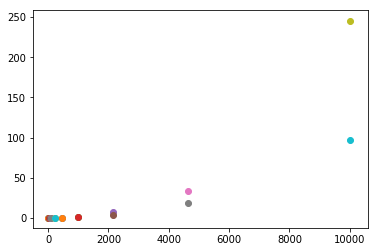

In [147]:
n_verts = 1000
n_dims = 10
X = np.random.uniform(size=(10,n_dims))
fast_rdpg_from_latent(X,X)

X = np.random.uniform(size=(n_verts,n_dims))
# run this once to get the first compilation for fair comparison
normal = []
fast = []
sizes = np.logspace(1,4,num=10,dtype=int)
for n_verts in sizes:
    X = np.random.uniform(size=(n_verts,n_dims))
    n = %timeit -r 1 -n 10 -o rdpg_from_latent(X, X)
    f = %timeit -r 1 -n 10 -o fast_rdpg_from_latent(X, X)
    normal.append(n)
    fast.append(f)

for i in range(len(normal)):
    t_normal = np.mean(normal[i].all_runs)
    t_fast = np.mean(fast[i].all_runs)
    plt.scatter(sizes[i],t_normal)
    plt.scatter(sizes[i],t_fast)
plt.show()

In [161]:
n_verts = 1000
n_dims = 10
n_sims = 100
X = np.random.uniform(size=(n_verts,n_dims))
fast_bootstrap(X, 2)

%timeit bootstrap(X,n_sims)
%timeit fast_bootstrap(X, n_sims)

1min 2s ± 2.74 s per loop (mean ± std. dev. of 7 runs, 1 loop each)
45.8 s ± 998 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [ ]:

# t_normal = np.zeros(n_sims)
# t_fast = np.zeros(n_sims)
# for i in range(n_sims):
#     t = time.process_time()
#     A1 = rdpg_from_latent(X)
#     t_normal[i] = t - time.process_time()
    
#     t = time.process_time()
#     A2 = fast_rdpg_from_latent(X,X)

#     t = time.process_time()
#     A3 = fast_rdpg_from_latent(X,X)
# t = time.process_time()
# spt = SemiparametricTest(n_components=2, n_bootstraps=500,)
# spt.fit(A1, A2)
# print('Normal')
# print('{0:.3f} mins'.format(((time.process_time() - t)/60)))

# t = time.process_time()
# fast_bootstrap(X, n_bootstraps)
# print('First Fast')
# print('{0:.3f} mins'.format(((time.process_time() - t)/60)))

# t = time.process_time()
# spt = FastSemiparametricTest(n_components=2, n_bootstraps=500,)
# spt.fit(A1, A2)
# print('Second Fast')
# print('{0:.3f} mins'.format(((time.process_time() - t)/60)))
